In [105]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import random
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Conv2DTranspose, MaxPooling2D, BatchNormalization, Activation, concatenate, Input, GlobalAveragePooling2D
from tensorflow.keras import Model
import warnings
 
warnings.filterwarnings("ignore")

ModuleNotFoundError: No module named 'tqdm'

In [107]:
# 재생산성을 위해 시드 고정
np.random.seed(7)
random.seed(7)
tf.random.set_seed(7)

NameError: name 'random' is not defined

In [85]:
def trainGenerator():
    
    train_path = 'train'
    train_files = sorted(glob.glob(train_path + '/*'))
    
    for file in train_files:
        
        dataset = np.load(file)
        
        target= dataset[:,:,-1].reshape(40,40,1)
        cutoff_labels = np.where(target < 0, 0, target)
        feature = dataset[:,:,:9]
        
        if (cutoff_labels > 0).sum() < 50:
            
            continue

        yield (feature, cutoff_labels)
        
train_dataset = tf.data.Dataset.from_generator(trainGenerator, (tf.float32, tf.float32), (tf.TensorShape([40,40,9]),tf.TensorShape([40,40,1])))

NameError: name 'tf' is not defined

In [86]:
train_dataset = train_dataset.batch(512).prefetch(1)

NameError: name 'train_dataset' is not defined

In [87]:
test_path = 'test'
test_files = sorted(glob.glob(test_path + '/*'))

X_test = []

for file in tqdm(test_files, desc = 'test'):
    
    data = np.load(file)
    
    X_test.append(data[:,:,:9])
                  
X_test = np.array(X_test)

NameError: name 'tqdm' is not defined

In [88]:
import seaborn as sns

In [89]:
color_map = plt.cm.get_cmap('RdBu')
color_map = color_map.reversed()

In [90]:
image_sample = np.load('train/subset_010462_02.npy')

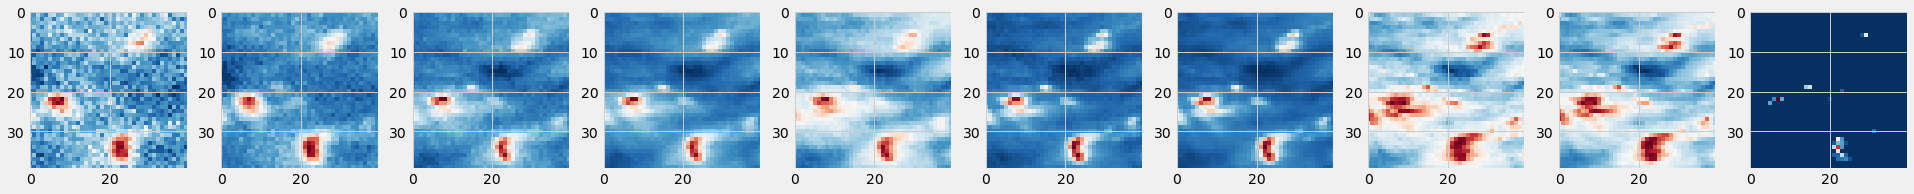

In [91]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(30, 30))

for i in range(9):
    plt.subplot(1,10,i+1)
    plt.imshow(image_sample[:, :, i], cmap=color_map)

plt.subplot(1,10,10)
plt.imshow(image_sample[:,:,-1], cmap = color_map)
plt.show()

In [92]:
def build_model(input_layer, start_neurons):
    
    # 40 x 40 -> 20 x 20
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D((2, 2))(pool1)
    pool1 = Dropout(0.25)(pool1)

    # 20 x 20 -> 10 x 10
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D((2, 2))(pool2)
    pool2 = Dropout(0.25)(pool2)

    # 10 x 10 
    convm = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)

    # 10 x 10 -> 20 x 20
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.25)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = BatchNormalization()(uconv2)

    # 20 x 20 -> 40 x 40
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.25)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = BatchNormalization()(uconv1)
    uconv1 = Dropout(0.25)(uconv1)
    output_layer = Conv2D(1, (1,1), padding="same", activation='relu')(uconv1)
    
    return output_layer

input_layer = Input((40, 40, 9))
output_layer = build_model(input_layer, 32)

NameError: name 'Input' is not defined

In [93]:
model = Model(input_layer, output_layer)

NameError: name 'Model' is not defined

In [94]:
from sklearn.metrics import f1_score

def mae(y_true, y_pred) :
    
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    y_true = y_true.reshape(1, -1)[0]
    
    y_pred = y_pred.reshape(1, -1)[0]
    
    over_threshold = y_true >= 0.1
    
    return np.mean(np.abs(y_true[over_threshold] - y_pred[over_threshold]))

def fscore(y_true, y_pred):
    
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    y_true = y_true.reshape(1, -1)[0]
    
    y_pred = y_pred.reshape(1, -1)[0]
    
    remove_NAs = y_true >= 0
    
    y_true = np.where(y_true[remove_NAs] >= 0.1, 1, 0)
    
    y_pred = np.where(y_pred[remove_NAs] >= 0.1, 1, 0)
    
    return(f1_score(y_true, y_pred))

def maeOverFscore(y_true, y_pred):
    
    return mae(y_true, y_pred) / (fscore(y_true, y_pred) + 1e-07)

def fscore_keras(y_true, y_pred):
    score = tf.py_function(func=fscore, inp=[y_true, y_pred], Tout=tf.float32, name='fscore_keras')
    return score

def maeOverFscore_keras(y_true, y_pred):
    score = tf.py_function(func=maeOverFscore, inp=[y_true, y_pred], Tout=tf.float32,  name='custom_mse') 
    return score

In [95]:
model.compile(loss="mae", optimizer="adam", metrics=[maeOverFscore_keras, fscore_keras])

NameError: name 'model' is not defined

In [96]:
model_history = model.fit(train_dataset, epochs = 2, verbose=1)

NameError: name 'model' is not defined

In [97]:
pred = model.predict(X_test)

NameError: name 'model' is not defined

In [98]:
submission = pd.read_csv('sample_submission.csv')

FileNotFoundError: File b'sample_submission.csv' does not exist

In [99]:
submission.iloc[:,1:] = pred.reshape(-1, 1600)

NameError: name 'pred' is not defined

In [100]:
submission.to_csv('Dacon_baseline.csv', index = False)

NameError: name 'submission' is not defined